<a href="https://colab.research.google.com/github/joseluisfalla/DSPS_JFalla/blob/main/HW6/HW6_DSPS_gaussian_process_regression_JFalla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.datasets import elnino
from scipy.optimize import minimize

!pip install george
import george
from george import kernels

# NB

Code skeletons are provided for you, but you may change them as you please.

It is not required, but I suggest you adjust and complete the given docstrings as you make changes.

# 0. The Dataset

We'll be using the El Niño dataset from the `statsmodels` package. This first cell of code loads the dataset easily for you. Read the description of the dataset [here](https://www.statsmodels.org/devel/datasets/generated/elnino.html).

In [2]:
def load_elnino_dataset():
    """
    Downloads the El Niño dataset from the statsmodels package.

    Parameters
    ----------
    None

    Returns
    -------
    df : pd.DataFrame
        A Pandas dataframe containing the raw data of the El Niño dataset
        directly from the statsmodels package.
    """
    df = elnino.load_pandas().data
    return df

df = load_elnino_dataset()

In [3]:
def flatten_dataset(df):
    """
    Flatten the data in the dataframe.

    The sea surface temperature data is stored in a somewhat peculiar way in
    this dataset. The data has rows for every year between 1950 and 2010, and
    it has 12 columns for each month of each year.

    Re-order the data such that there is one 1-dim array for the temperature data.

    Parameters
    ----------
    df : pd.DataFrame
        The Pandas dataframe of the El Niño – Sea Surface Temperature dataset
        from the statsmodels package.

    Returns
    -------
    time : array-like
        A shape (732,) array containing every month from January 1950 to
        December 2010. You may encode the time as an integer
        (`time = [0, 1, 2, 3, ...]), as strings (`time = ['January 1950', ...])
        or however else you like.
    data : array-like
        A shape (732,) array containing the sea surface temperature for every
        month between January 1950 to December 2010.
    """

    df = df.iloc[:, 1:]
    data = np.array(df.values).reshape(-1)
    time = np.arange(data.shape[0])

    # raise NotImplementedError()

    return time, data

x, y = flatten_dataset(df)
days = (x / 12) * 365.25

# 1. Visualize

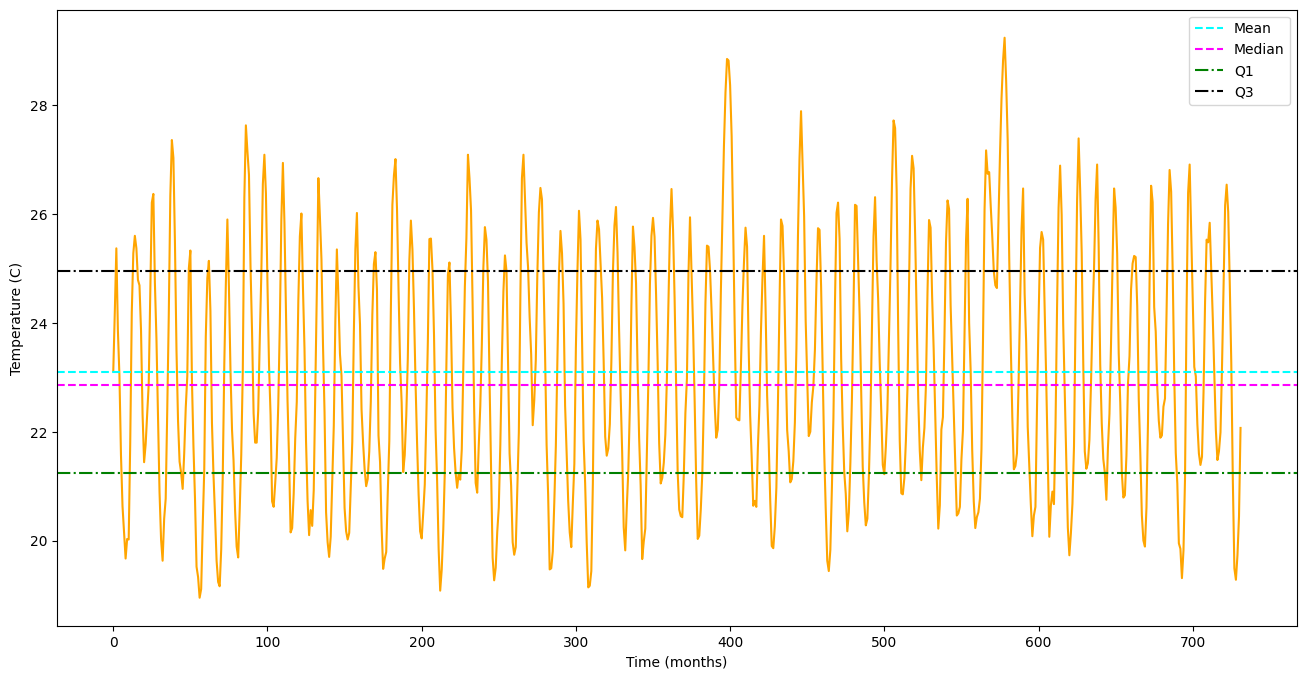

In [4]:
def visualize(df):
    """
    Visualize the El Niño – Sea Surface Temperature dataset.

    You decide the most appropriate way to visualize the dataset.

    Parameters
    ----------
    df : pd.DataFrame
        The Pandas dataframe of the El Niño – Sea Surface Temperature dataset
        from the statsmodels package.

    Returns
    -------
    None
    """

    fig, ax = plt.subplots(figsize=(16, 8))
    x, y = flatten_dataset(df)
    ax.plot(x, y, color='orange')
    ax.axhline(np.mean(y), label='Mean', linestyle='--', color='cyan')
    ax.axhline(np.median(y), label='Median', linestyle='--', color='magenta')
    ax.axhline(np.percentile(y, 25), label='Q1', linestyle='dashdot', color='green')
    ax.axhline(np.percentile(y, 75), label='Q3', linestyle='dashdot', color='black')

    ax.legend()
    ax.set_xlabel('Time (months)')
    ax.set_ylabel('Temperature (C)')

    # raise NotImplementedError()

visualize(df)

Figure 1. Visualization of averaged monthly sea surface temperature in degree Celsius of the Pacific Ocean between 1950-2010. Both the mean (cyan) and the median (magenta) are plotted, as well as the lower and upper quartiles (green and black, respectively).

# 2. Gaussian Process Regression (GPR)

In [5]:
def get_interpolated_time():
    """
    We are going to use GPR to interpolate the sea surface temperatures for
    every day between January 1st 1950 and December 1st 2030. There are 29,555
    days between those two dates (inclusive). Create and return an array of
    times for each day in that timeframe.

    Paramters
    ---------
    None

    Returns
    -------
    interp_time : array-like
        A shape (29555,) array, the times we want to interpolate. Encoded the
        same way you did before or any way you like.
    """

    # raise NotImplementedError()
    return np.arange(int(np.rint(365.25 * 81 - 30)))

t = get_interpolated_time()

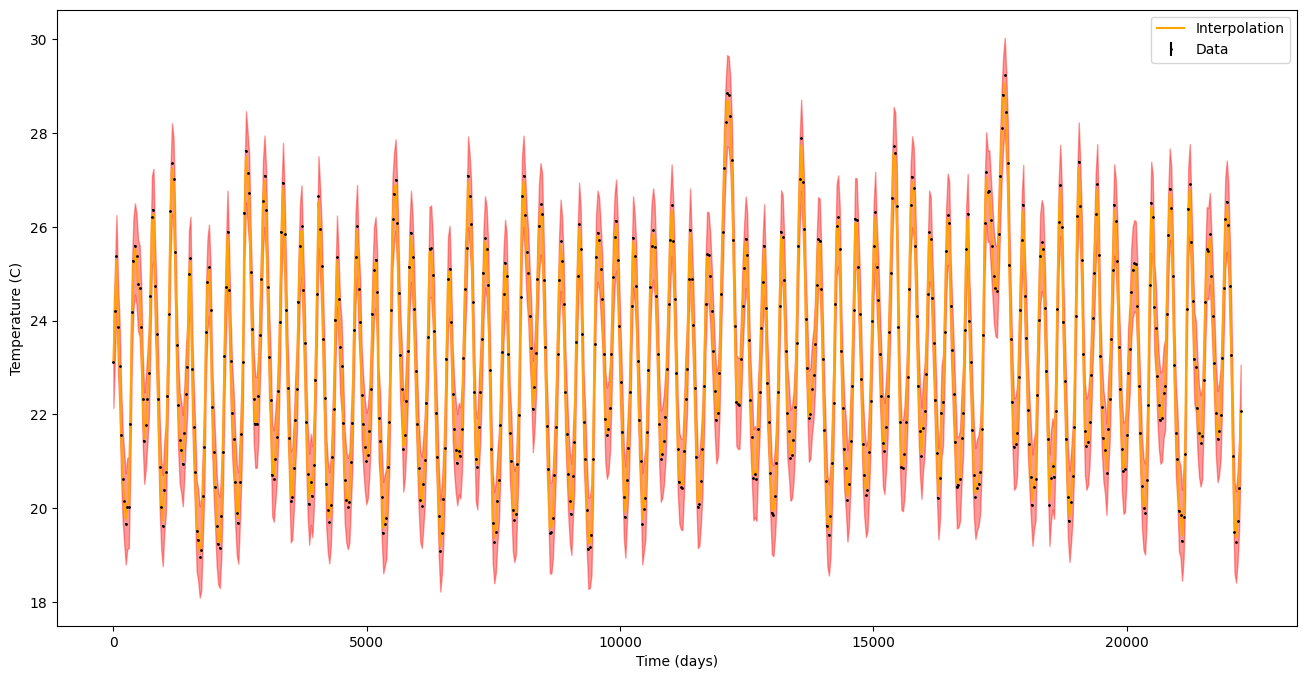

In [6]:
def gaussian_process_regression(time, data, interp_time, initial_guess):
    """
    Using the george package, its documentation and startup guide, implement a
    gaussian process regressor on `time` and `data`. Then, use it to predict
    on `interp_time`.

    It will be helpful for you to write code to visualize the result of this
    initial model, but not necessary for the assignment.

    Parameters
    ----------
    time : array-like
        A shape (732,) array, times between 1950 and 2010, sampled every month.
    data : array-like
        A shape (732,) array, sea surface temperatures every month between 1950
        and 2010.
    interp_time : array-like
        A shape (29555,) array, times between 1950 and 2030, sampled every day.
    initial_guess : array-like or float
        The intial guess for the gaussian process that you make. The number of
        parameters will depend on the kernel you choose.

    Returns
    -------
    None
    """

    t, d, it = initial_guess
    kernel = t * kernels.ExpSquaredKernel(d) + kernels.ConstantKernel(log_constant=it)

    # GP regression model
    gp = george.GP(kernel, white_noise=1e-8)
    gp.compute(time)

    time_interp = time[:27500]

    # Do GP regression to interpolate values at time_interp
    mean_interp, std_interp = gp.predict(data, time_interp, return_var=True)

    # Plot the original data and the GP interpolation
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.errorbar(time, data, yerr=0.01, fmt='ok', markersize=1, label='Data')
    ax.plot(time_interp, mean_interp, color='orange', label='Interpolation')
    ax.fill_between(time_interp, mean_interp - np.sqrt(std_interp), mean_interp + np.sqrt(std_interp), color='red', alpha=0.4)
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Temperature (C)')
    ax.legend()


    # raise NotImplementedError()

initial_guess = (22, 400, 20)
gaussian_process_regression(days, y, t, initial_guess)

Figure 2. Visualization of the interpolation (orange) of the data (black dots). I don't know why from the initial guess it seems like the interpolation is correct and there's not a lot of uncertainty.

# 3. Optimize

In [7]:
def optimize(time, data, initial_guess):
    """
    Using any optimization method you choose, find the optimal set of
    hyperparameters for your model.

    Print the results of your optimization.

    Parameters
    ----------
    ...

    Returns
    -------
    None
    """
    def log_likelihood(theta):
      t, d, it = theta
      kernel = t * kernels.ExpSquaredKernel(d) + kernels.ConstantKernel(log_constant=it)
      gp = george.GP(kernel, white_noise=1e-8)
      gp.compute(time)
      log_like = gp.lnlikelihood(data)
      return -log_like

    bounds = [(1, 40), (100, 600), (-20, 20)]
    result = minimize(log_likelihood, initial_guess, bounds=bounds)
    opt_params = result.x

    # raise NotImplementedError()
    return opt_params

opt_params = optimize(days, y, initial_guess)

# 4. Visualize your model

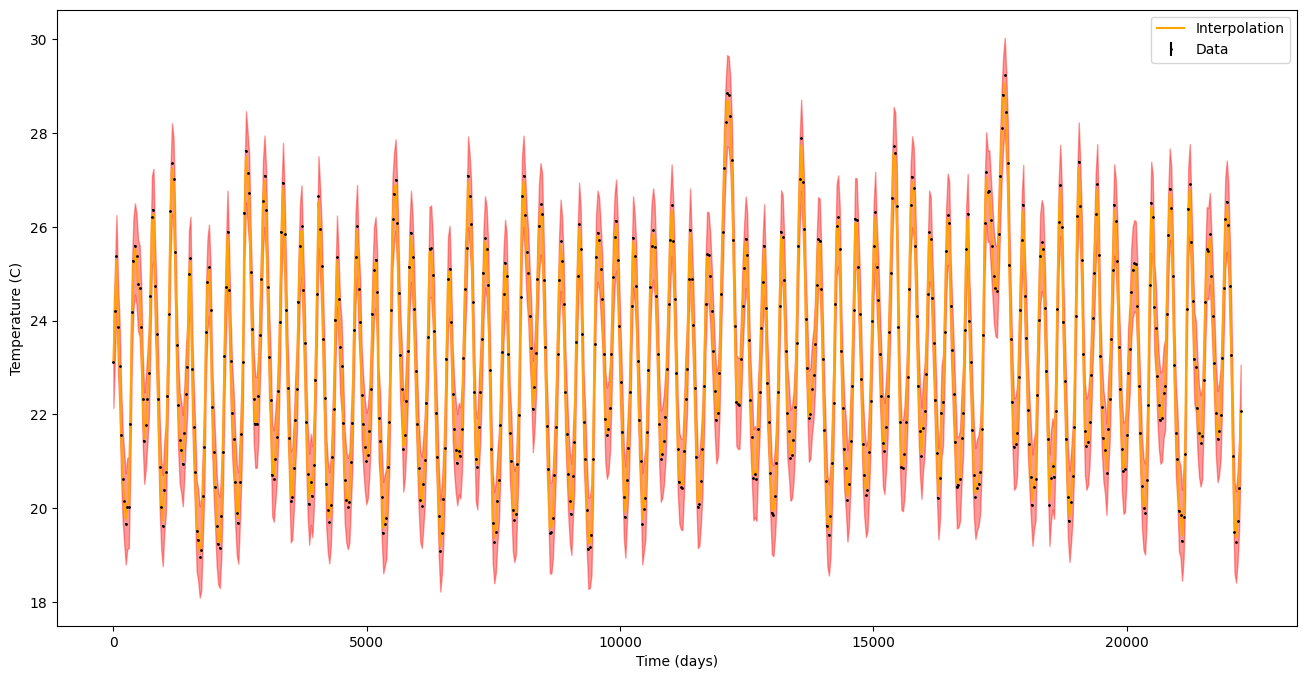

In [8]:
def visualize_model(opt_params):
    """
    Visualize your model. Use any method you like in visualizing your model but
    you must make at least one plot with a figure caption. Your
    visualization must also plot the uncertainties from the GP model.

    In your figure caption, comment on the effectiveness of your model in
    predicting temperatures beyond 2010.

    Parameters
    ----------


    Returns
    -------

    """
    gaussian_process_regression(days, y, t, opt_params)
    # raise NotImplementedError()

visualize_model(opt_params)

Figure 3. Same as Figure 2 (even though this should be the correct version of Figure 2). It looks like GP is working well to predict future sea temperatures as a result of El Nino.